In [1]:
import numpy as np
import torch
from torch import nn
from torch.optim import *
from torchvision.datasets import *
from torchvision.transforms import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune
from torchsummary import summary
from tqdm.auto import tqdm
import os
import random
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def seed_random():
  seed = 42
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# https://stackoverflow.com/a/1094933
def humanize(num, suffix="B"):
    for unit in ("", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"):
        if abs(num) < 1024.0:
            return f"{num:3.5f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.5f}Yi{suffix}"

In [4]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    inputs = inputs.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    outputs = outputs.argmax(dim=1)
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bytes
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width / 8

image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "test": Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
}

dataset = {}

for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )

dataloader = {}

for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

100%|██████████| 170498071/170498071 [00:03<00:00, 55287032.83it/s]


Extracting data/cifar10/cifar-10-python.tar.gz to data/cifar10
Files already downloaded and verified


In [5]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [26]:
batch_size = 128
model = VGG('VGG11').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

In [ ]:
humanize(get_model_size(model))

'35.21391MiB'

In [ ]:
get_num_parameters(model), get_num_parameters(model, True).item()

(9231114, 9228362)

In [ ]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [ ]:
conv_layers = [0,4,8,11,15,18,22,25]
conv_layer_sizes = [1792, 73856, 295168, 590080, 1180160, 2359808, 2359808, 2359808]

In [ ]:
def prune_hook(module, input, output):
    weight = module.weight.data
    mask = torch.ones_like(weight)
    mask[weight == 0] = 0  # Create a mask for the pruned weights
    module.weight.data.mul_(mask)  # Apply the mask to the weight tensor

In [ ]:
results = []

for conv_layer_idx, conv_layer_size in zip(conv_layers, conv_layer_sizes):
  # reinitialise the model for sensitivity scan of each conv layer
  seed_random()
  model = VGG('VGG11').to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())
  print(f"Sensitvity scan: Layer {conv_layer_idx} | Size {conv_layer_size}")

  # train the model for 10 rounds
  for _ in tqdm(range(10),desc='epoch', leave=False):
    train(model, dataloader['train'], criterion, optimizer)

  # initial sparsity and accuracy
  sparsity,accuracy = get_sparsity(model.features[conv_layer_idx].weight), evaluate(model, dataloader['test'])
  print(f"Sparsity: {sparsity} | Accuracy: {accuracy} | Size: {humanize(get_model_size(model))} - {humanize(get_model_size(model, True))}")
  results.append([[sparsity,accuracy]])

  for i in range(1,10):
    prune.l1_unstructured(model.features[conv_layer_idx], name="weight", amount=i/10)
    prune.remove(model.features[conv_layer_idx], "weight")
    model.features[conv_layer_idx].register_forward_hook(prune_hook)
    sparsity,accuracy = get_sparsity(model.features[conv_layer_idx].weight), evaluate(model, dataloader['test'])
    print(f"Sparsity: {sparsity} | Accuracy: {accuracy} | Size: {humanize(get_model_size(model))} - {humanize(get_model_size(model, True))}")
    results[-1].append([sparsity,accuracy])

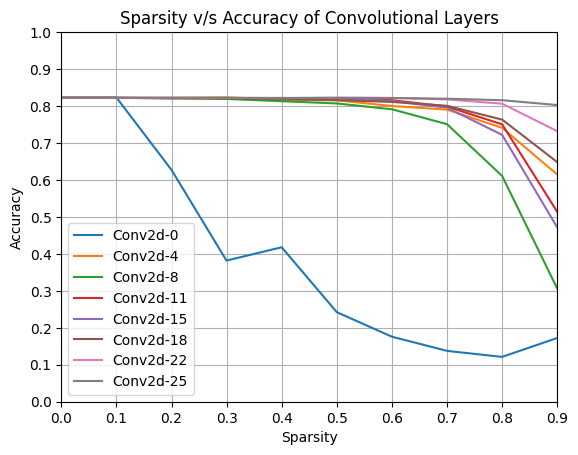

In [ ]:
%matplotlib inline
for i,line in enumerate(results):
    x = [point[0] for point in line]
    y = [point[1]/100 for point in line]
    plt.plot(x, y, label=f"Conv2d-{conv_layers[i]}")

plt.xlabel('Sparsity')
plt.xlim(0,0.9)
plt.ylim(0,1)
plt.xticks([i/100 for i in range(10)])
plt.yticks([i/100 for i in range(11)])
plt.ylabel('Accuracy')
plt.title('Sparsity v/s Accuracy of Convolutional Layers')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
conv_layers = [0,4,8,11,15,18,22,25]
conv_layer_sparsity = [0.1, 0.7, 0.5, 0.7, 0.7, 0.7, 0.8, 0.9]

In [60]:
%matplotlib inline
def plot_weight_distribution(model, layer_idxs, is_pruned=False):
    for layer_idx in layer_idxs:
        weights = model.features[layer_idx].weight.data.cpu().numpy().flatten()
        if is_pruned:
            title = f"Conv2D {[layer_idx]} (After Pruning)"
        else:
            title = f"Conv2D {[layer_idx]} (Before Pruning)"

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.hist(weights, bins=50)
        ax.set_title(title)
        ax.set_xlabel("Weight Value")
        ax.set_ylabel("Count")
        plt.show()

In [61]:
batch_size = 128
model = VGG('VGG11').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

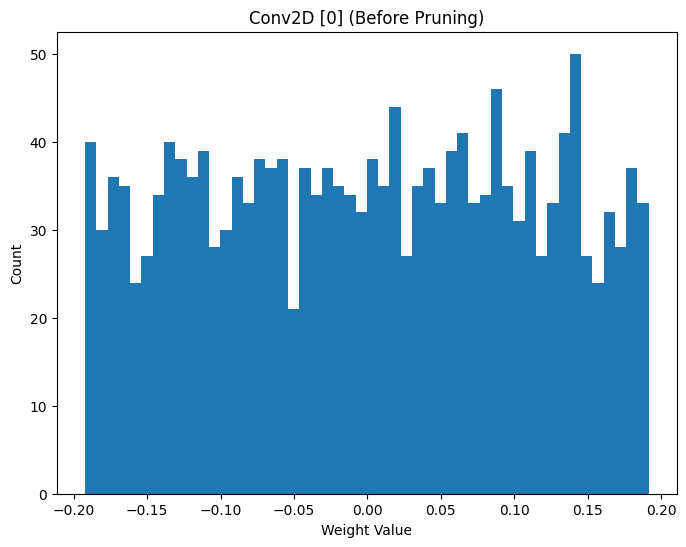

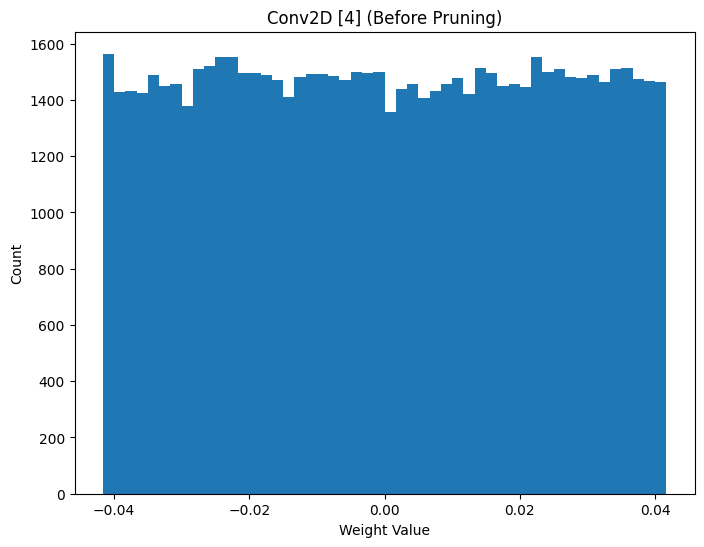

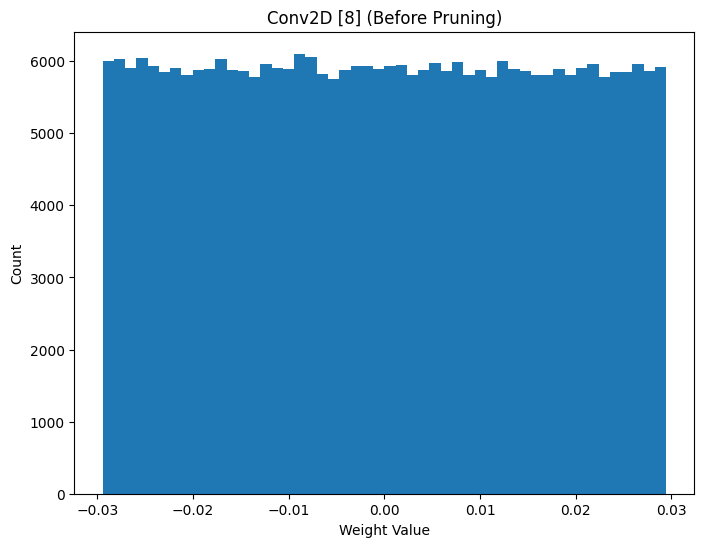

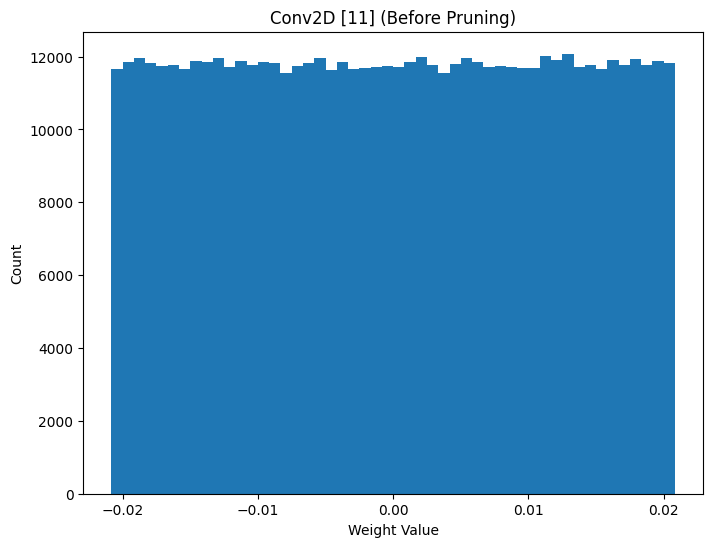

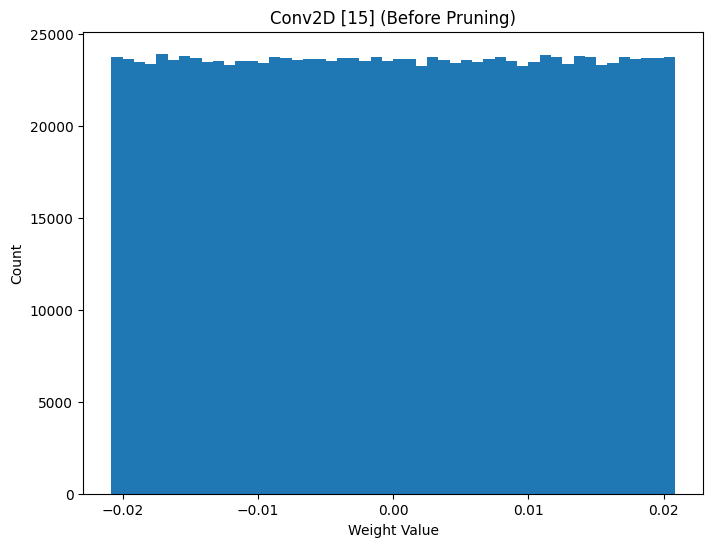

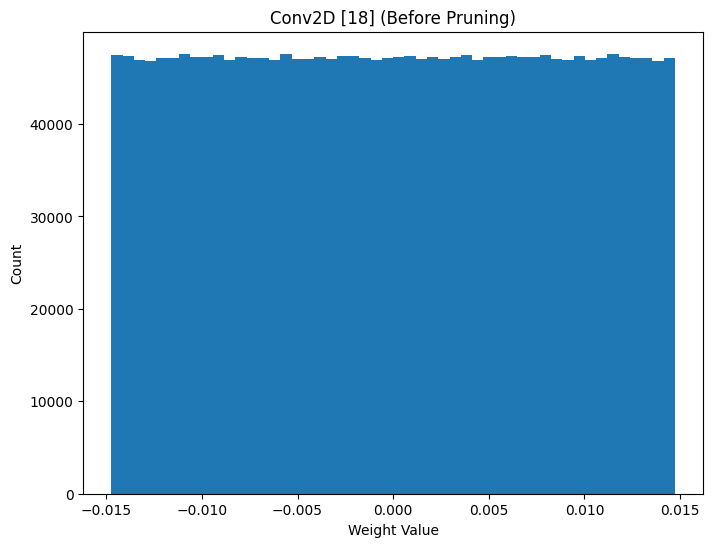

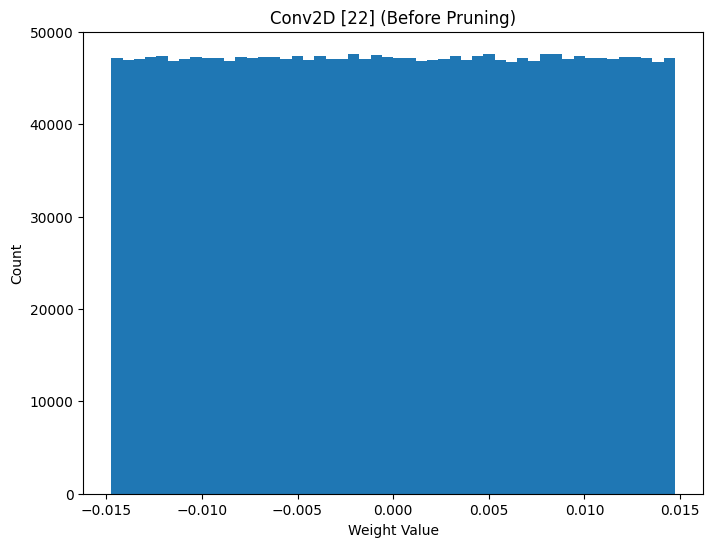

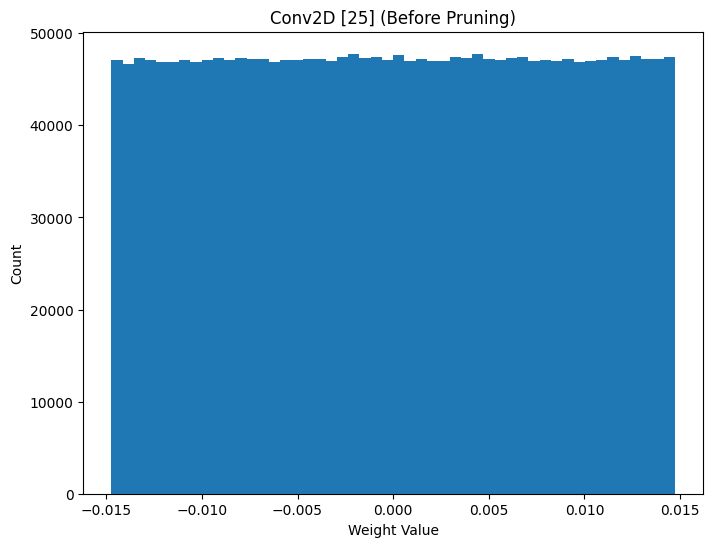

In [62]:
plot_weight_distribution(model, conv_layers)

In [63]:
for _ in tqdm(range(30),desc='epoch', leave=False):
    train(model, dataloader['train'], criterion, optimizer)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

train:   0%|          | 0/98 [00:00<?, ?it/s]

In [64]:
accuracy = evaluate(model, dataloader['test'])
non_zero_params_pre_pruning = get_num_parameters(model, True).item()
print(f"Pre-pruning Accuracy: {accuracy:.3f}%")
print(f"Size: {non_zero_params_pre_pruning}")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Pre-pruning Accuracy: 87.230%
Size: 9231114


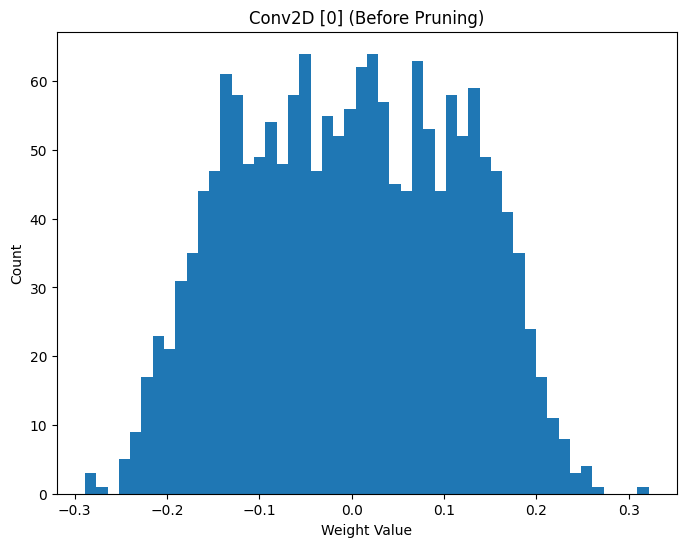

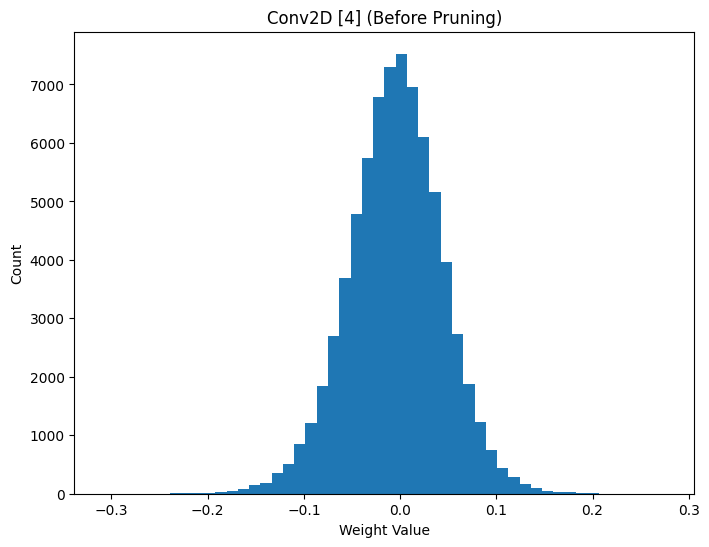

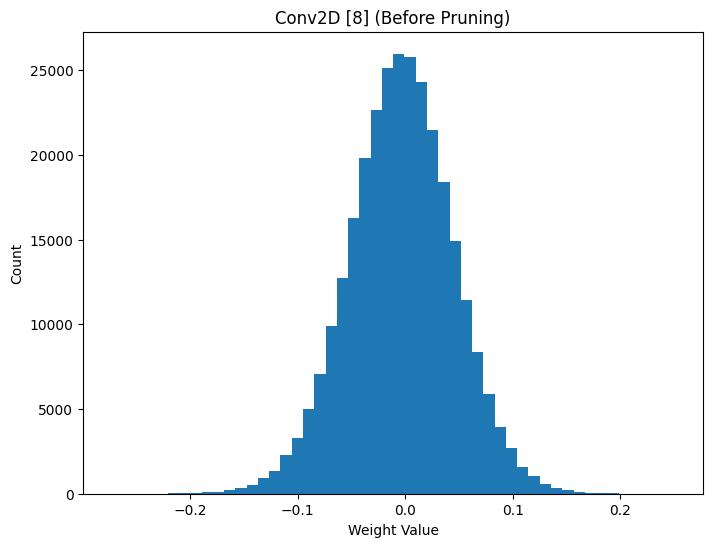

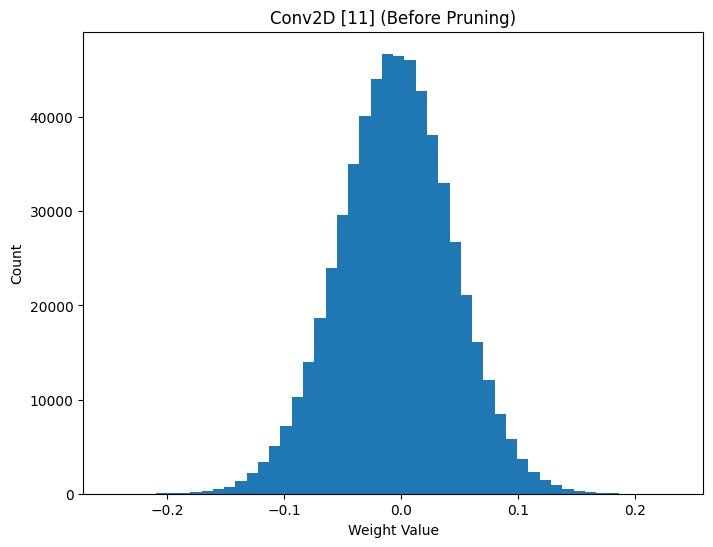

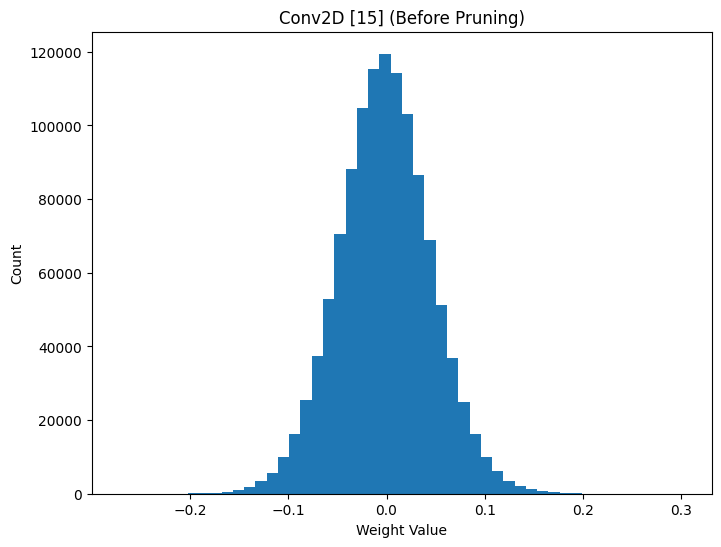

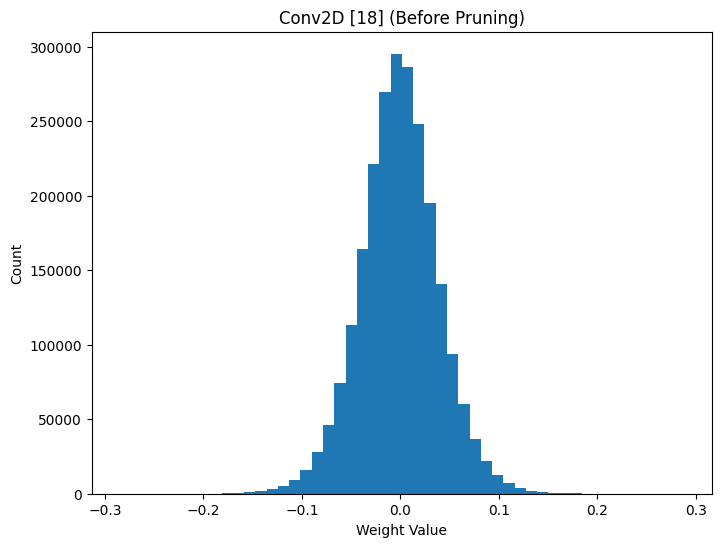

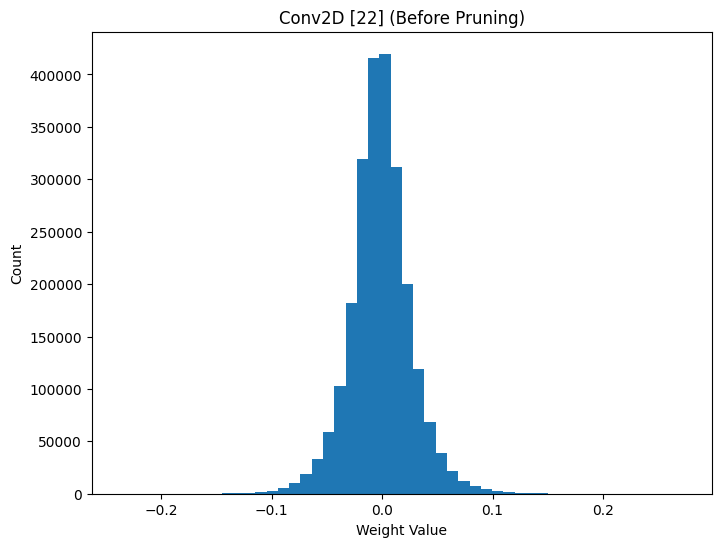

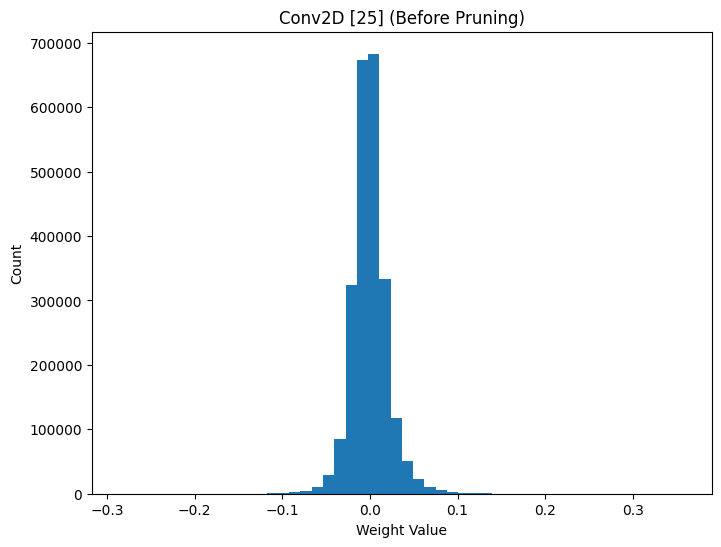

In [65]:
plot_weight_distribution(model, conv_layers)

In [66]:
for (conv_layer_idx, conv_layer_spx) in zip(conv_layers, conv_layer_sparsity):
     prune.l1_unstructured(model.features[conv_layer_idx], name="weight", amount=conv_layer_spx)
    #  prune.remove(model.features[conv_layer_idx], "weight")

In [67]:
accuracy = evaluate(model, dataloader['test'])
print(f"Post-pruning Accuracy: {accuracy:.3f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Post-pruning Accuracy: 41.710%


In [ ]:
for _ in tqdm(range(10),desc='epoch', leave=False):
    train(model, dataloader['train'], criterion, optimizer)

In [71]:
accuracy = evaluate(model, dataloader['test'])
print(f"Fine-tuned Accuracy: {accuracy:.3f}%")

eval:   0%|          | 0/20 [00:00<?, ?it/s]

Fine-tuned Accuracy: 88.810%


In [73]:
for (conv_layer_idx, conv_layer_spx) in zip(conv_layers, conv_layer_sparsity):
    #  prune.l1_unstructured(model.features[conv_layer_idx], name="weight", amount=conv_layer_spx)
     prune.remove(model.features[conv_layer_idx], "weight")

In [74]:
non_zero_params_post_pruning = get_num_parameters(model, True).item()
print(f"Size: {non_zero_params_post_pruning}")

Size: 2130934


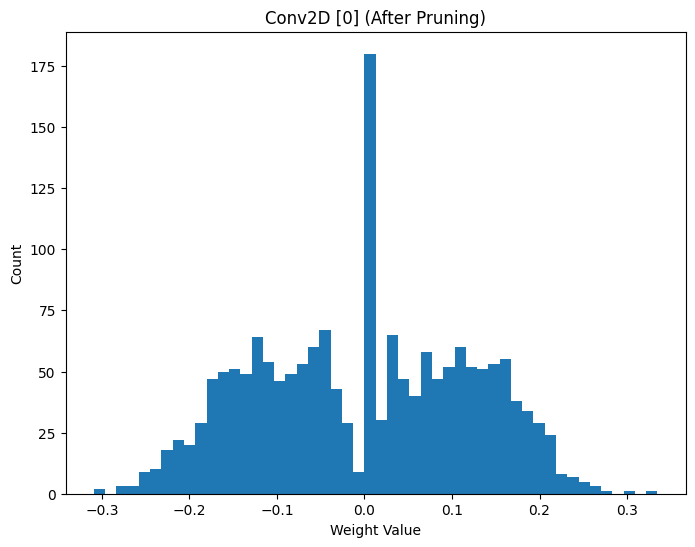

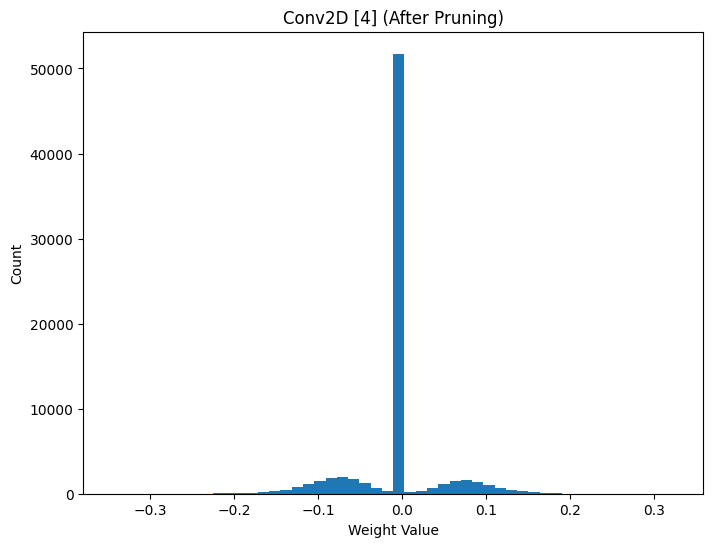

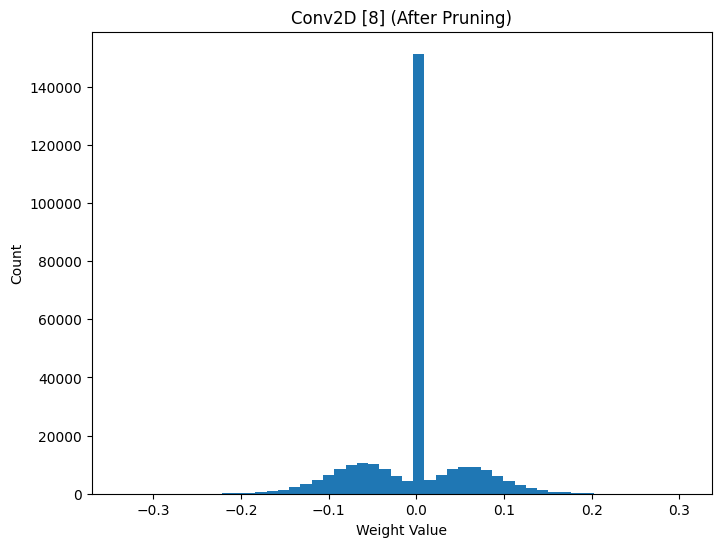

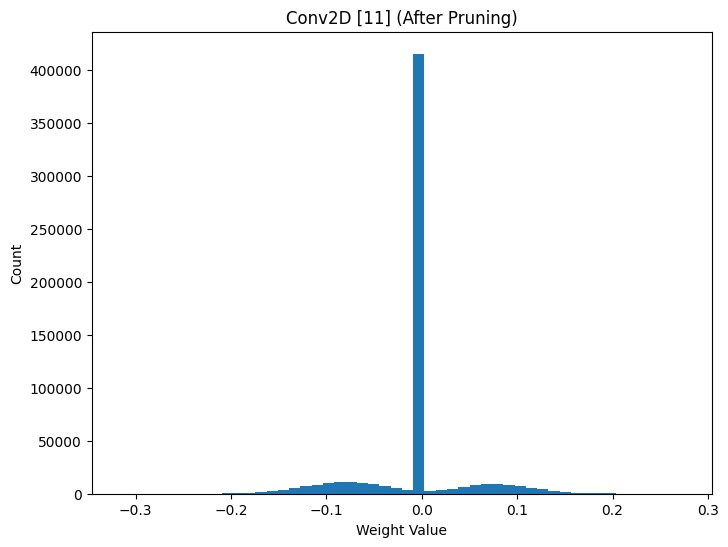

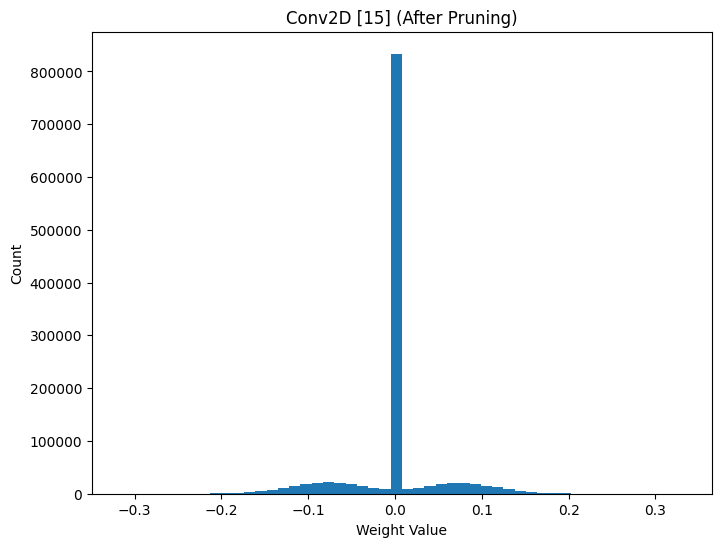

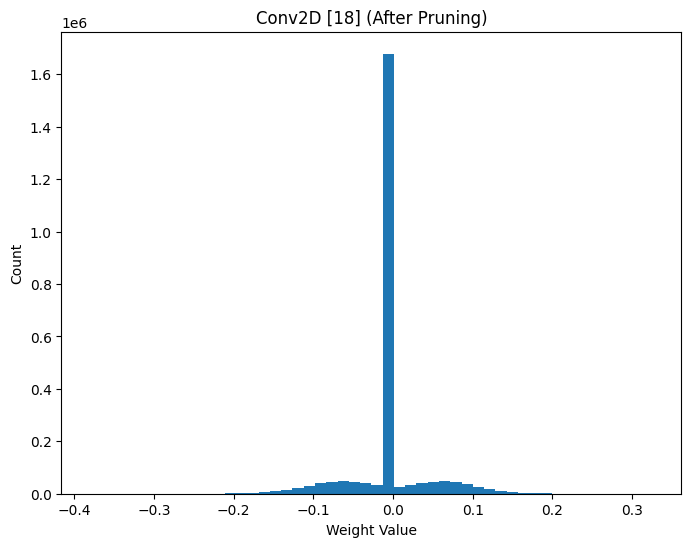

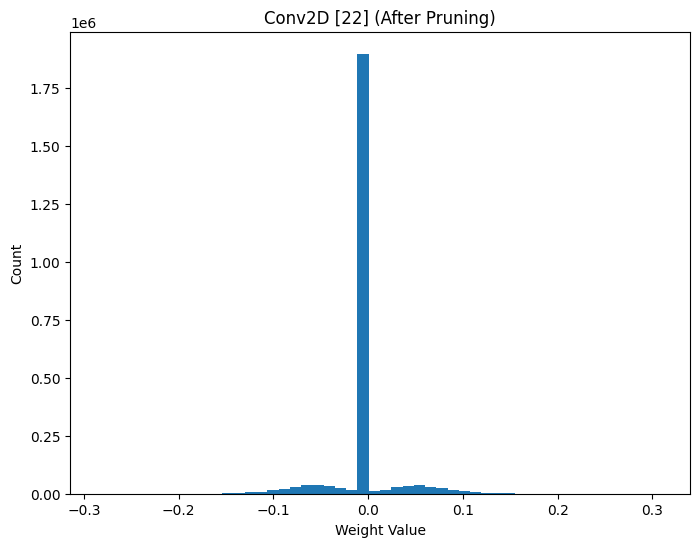

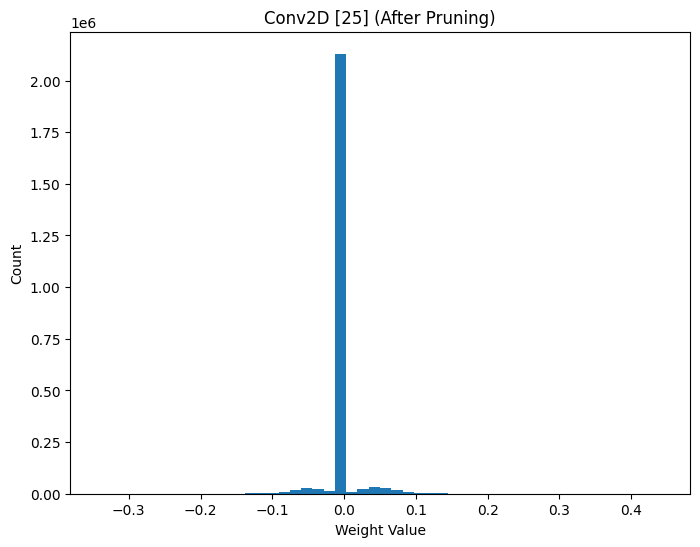

In [75]:
plot_weight_distribution(model, conv_layers, True)

In [77]:
print(f"Compression Ratio: {non_zero_params_post_pruning/non_zero_params_pre_pruning*100:.3f}%")

Compression Ratio: 23.084%
